In [1]:
import importers
import importlib
importlib.reload(importers)
from importers import SpikeImporter

data_folder = "../data/"
file_name = "11_10_27U2a_2000s_2300s_20000Hz_Force_BigFibre"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["801 nw-1", "12 nw-1"]
force_channel = "3 Force"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, \
                         time_channel = time_channel, signal_channel = signal_channel, stimulus_channel = stimulus_channel, \
                         ap_marker_channels = ap_marker_channels, force_channel = force_channel)

print("Data loaded.")

Data loaded.


In [2]:
# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005
force_thresh = 0.5

# retrieve the events from the importer 
el_stimuli = importer.getElectricalStimuli()
mech_stimuli = importer.getMechanicalStimuli(threshold = force_thresh, max_gap_time = 0.005)
actpots = importer.getActionPotentials(max_gap_time = max_gap_time, el_stimuli = el_stimuli, mech_stimuli = mech_stimuli)

List of eletrical stimuli created.
List of mechanical stimuli created.
Found action potential with:
onset = 0.06615s offset = 0.0673s
normalized energy = 335.88988916666665
dist. to prev. el. stimulus = 0.0097s
dist. to prev. mech. stimulus = -32.78725s

Found action potential with:
onset = 0.3164s offset = 0.31755s
normalized energy = 284.55298508333334
dist. to prev. el. stimulus = 0.009700000000000042s
dist. to prev. mech. stimulus = -32.537s

Found action potential with:
onset = 0.5666s offset = 0.56775s
normalized energy = 331.15741925000003
dist. to prev. el. stimulus = 0.009700000000000042s
dist. to prev. mech. stimulus = -32.2868s

Found action potential with:
onset = 0.81685s offset = 0.818s
normalized energy = 234.416317625
dist. to prev. el. stimulus = 0.009749999999999925s
dist. to prev. mech. stimulus = -32.03655s

Found action potential with:
onset = 1.067s offset = 1.06815s
normalized energy = 270.2434835
dist. to prev. el. stimulus = 0.009649999999999936s
dist. to prev.

Found action potential with:
onset = 10.5756s offset = 10.57675s
normalized energy = 280.1741338749999
dist. to prev. el. stimulus = 0.009700000000000486s
dist. to prev. mech. stimulus = -22.2778s

Found action potential with:
onset = 10.82585s offset = 10.827s
normalized energy = 337.6517500833333
dist. to prev. el. stimulus = 0.009700000000000486s
dist. to prev. mech. stimulus = -22.027549999999998s

Found action potential with:
onset = 11.07615s offset = 11.0773s
normalized energy = 408.6955620416668
dist. to prev. el. stimulus = 0.00975000000000037s
dist. to prev. mech. stimulus = -21.777250000000002s

Found action potential with:
onset = 11.32635s offset = 11.3275s
normalized energy = 265.91396341666666
dist. to prev. el. stimulus = 0.009700000000000486s
dist. to prev. mech. stimulus = -21.527050000000003s

Found action potential with:
onset = 11.5766s offset = 11.57775s
normalized energy = 287.5410664583333
dist. to prev. el. stimulus = 0.00969999999999871s
dist. to prev. mech. s

Found action potential with:
onset = 23.58805s offset = 23.5892s
normalized energy = 276.86315237499997
dist. to prev. el. stimulus = 0.009650000000000603s
dist. to prev. mech. stimulus = -9.265350000000002s

Found action potential with:
onset = 23.8383s offset = 23.83945s
normalized energy = 291.6762704166667
dist. to prev. el. stimulus = 0.009650000000000603s
dist. to prev. mech. stimulus = -9.0151s

Found action potential with:
onset = 24.0885s offset = 24.08965s
normalized energy = 375.37509924999995
dist. to prev. el. stimulus = 0.009599999999998943s
dist. to prev. mech. stimulus = -8.7649s

Found action potential with:
onset = 24.33875s offset = 24.3399s
normalized energy = 319.36736137500003
dist. to prev. el. stimulus = 0.009650000000000603s
dist. to prev. mech. stimulus = -8.51465s

Found action potential with:
onset = 24.58905s offset = 24.5902s
normalized energy = 383.2244149166666
dist. to prev. el. stimulus = 0.00969999999999871s
dist. to prev. mech. stimulus = -8.26435s



Found action potential with:
onset = 32.95165s offset = 32.9528s
normalized energy = 296.12209820833345
dist. to prev. el. stimulus = 0.1136499999999998s
dist. to prev. mech. stimulus = 0.09825000000000017s

Found action potential with:
onset = 32.96135s offset = 32.9625s
normalized energy = 313.53246179166666
dist. to prev. el. stimulus = 0.12335000000000207s
dist. to prev. mech. stimulus = 0.10795000000000243s

Found action potential with:
onset = 32.97135s offset = 32.9725s
normalized energy = 347.1859315416668
dist. to prev. el. stimulus = 0.13335000000000008s
dist. to prev. mech. stimulus = 0.11795000000000044s

Found action potential with:
onset = 32.98085s offset = 32.982s
normalized energy = 264.03277116666675
dist. to prev. el. stimulus = 0.1428499999999957s
dist. to prev. mech. stimulus = 0.12744999999999607s

Found action potential with:
onset = 32.9904s offset = 32.99155s
normalized energy = 282.40570491666665
dist. to prev. el. stimulus = 0.1524000000000001s
dist. to prev.

Found action potential with:
onset = 40.60265s offset = 40.6038s
normalized energy = 277.91015275000007
dist. to prev. el. stimulus = 0.010199999999997544s
dist. to prev. mech. stimulus = 7.749249999999996s

Found action potential with:
onset = 40.85295s offset = 40.8541s
normalized energy = 366.9854920833333
dist. to prev. el. stimulus = 0.010249999999999204s
dist. to prev. mech. stimulus = 7.999549999999999s

Found action potential with:
onset = 41.1031s offset = 41.1043s
normalized energy = 303.8468622
dist. to prev. el. stimulus = 0.010199999999997544s
dist. to prev. mech. stimulus = 8.249699999999997s

Found action potential with:
onset = 41.35335s offset = 41.3545s
normalized energy = 279.5235489583334
dist. to prev. el. stimulus = 0.010249999999999204s
dist. to prev. mech. stimulus = 8.499949999999998s

Found action potential with:
onset = 41.60355s offset = 41.6047s
normalized energy = 235.84055750000002
dist. to prev. el. stimulus = 0.010199999999997544s
dist. to prev. mech. s

Found action potential with:
onset = 52.8633s offset = 52.86445s
normalized energy = 291.363667875
dist. to prev. el. stimulus = 0.01004999999999967s
dist. to prev. mech. stimulus = 20.009900000000002s

Found action potential with:
onset = 53.11345s offset = 53.1146s
normalized energy = 391.26189979166674
dist. to prev. el. stimulus = 0.00999999999999801s
dist. to prev. mech. stimulus = 20.26005s

Found action potential with:
onset = 53.3637s offset = 53.36485s
normalized energy = 332.45151175000007
dist. to prev. el. stimulus = 0.00999999999999801s
dist. to prev. mech. stimulus = 20.5103s

Found action potential with:
onset = 53.6139s offset = 53.61505s
normalized energy = 225.58422087500003
dist. to prev. el. stimulus = 0.00999999999999801s
dist. to prev. mech. stimulus = 20.7605s

Found action potential with:
onset = 53.8641s offset = 53.86525s
normalized energy = 328.5502115
dist. to prev. el. stimulus = 0.00999999999999801s
dist. to prev. mech. stimulus = 21.0107s

Found action po

Found action potential with:
onset = 64.62355s offset = 64.6247s
normalized energy = 286.5528665416667
dist. to prev. el. stimulus = 0.009949999999989245s
dist. to prev. mech. stimulus = 31.770149999999994s

Found action potential with:
onset = 64.87375s offset = 64.8749s
normalized energy = 268.81374741666673
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 32.02035s

Found action potential with:
onset = 65.12395s offset = 65.1251s
normalized energy = 214.8761920833333
dist. to prev. el. stimulus = 0.009899999999987585s
dist. to prev. mech. stimulus = 32.27054999999999s

Found action potential with:
onset = 65.37415s offset = 65.3753s
normalized energy = 326.2265122916666
dist. to prev. el. stimulus = 0.009900000000001796s
dist. to prev. mech. stimulus = 32.52075s

Found action potential with:
onset = 65.62435s offset = 65.6255s
normalized energy = 300.9931310833333
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 3

Found action potential with:
onset = 76.634s offset = 76.63515s
normalized energy = 330.2113197083334
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 43.7806s

Found action potential with:
onset = 76.88425s offset = 76.8854s
normalized energy = 272.576068
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 44.030849999999994s

Found action potential with:
onset = 77.13445s offset = 77.1356s
normalized energy = 325.22968699999996
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 44.28105s

Found action potential with:
onset = 77.38465s offset = 77.3858s
normalized energy = 231.45927970833327
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 44.53124999999999s

Found action potential with:
onset = 77.63485s offset = 77.636s
normalized energy = 310.0731659166667
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 44.78145s


Found action potential with:
onset = 87.64365s offset = 87.6448s
normalized energy = 310.51431683333334
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 54.79024999999999s

Found action potential with:
onset = 87.89385s offset = 87.895s
normalized energy = 318.74347399999994
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 55.04045s

Found action potential with:
onset = 88.1441s offset = 88.14525s
normalized energy = 218.86205462500004
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 55.290699999999994s

Found action potential with:
onset = 88.3943s offset = 88.39545s
normalized energy = 261.93745095833333
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 55.5409s

Found action potential with:
onset = 88.64455s offset = 88.6457s
normalized energy = 244.54247670833334
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus =

Found action potential with:
onset = 100.1546s offset = 100.15575s
normalized energy = 266.35418874999993
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. stimulus = 67.3012s

Found action potential with:
onset = 100.40485s offset = 100.406s
normalized energy = 254.8615005416666
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 67.55144999999999s

Found action potential with:
onset = 100.6551s offset = 100.65625s
normalized energy = 290.08381170833326
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 67.80170000000001s

Found action potential with:
onset = 100.9053s offset = 100.90645s
normalized energy = 214.89965204166666
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 68.05189999999999s

Found action potential with:
onset = 101.1555s offset = 101.15665s
normalized energy = 302.6039019583333
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. 

Found action potential with:
onset = 112.16515s offset = 112.1663s
normalized energy = 251.3811734166666
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. stimulus = 79.31174999999999s

Found action potential with:
onset = 112.41535s offset = 112.4165s
normalized energy = 266.51298625
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. stimulus = 79.56195s

Found action potential with:
onset = 112.6656s offset = 112.66675s
normalized energy = 330.3485846666667
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. stimulus = 79.81219999999999s

Found action potential with:
onset = 112.91585s offset = 112.917s
normalized energy = 269.5077279166666
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 80.06245000000001s

Found action potential with:
onset = 113.16605s offset = 113.1672s
normalized energy = 328.8781662916667
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. s

Found action potential with:
onset = 123.9255s offset = 123.92665s
normalized energy = 371.4159307916666
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. stimulus = 91.0721s

Found action potential with:
onset = 124.10585s offset = 124.107s
normalized energy = 144.67904399999998
dist. to prev. el. stimulus = 0.19010000000000105s
dist. to prev. mech. stimulus = 91.25245000000001s

Found action potential with:
onset = 124.17575s offset = 124.1769s
normalized energy = 468.5445910833332
dist. to prev. el. stimulus = 0.009799999999998477s
dist. to prev. mech. stimulus = 91.32235s

Found action potential with:
onset = 124.42595s offset = 124.4271s
normalized energy = 496.9941568333333
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. stimulus = 91.57255s

Found action potential with:
onset = 124.67615s offset = 124.6773s
normalized energy = 247.54179662499996
dist. to prev. el. stimulus = 0.009750000000011028s
dist. to prev. mech. stimulus = 91.

Found action potential with:
onset = 134.4348s offset = 134.43595s
normalized energy = 261.5822415833333
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 101.5814s

Found action potential with:
onset = 134.685s offset = 134.68615s
normalized energy = 248.75967533333332
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 101.83160000000001s

Found action potential with:
onset = 134.9352s offset = 134.93635s
normalized energy = 301.4461853333334
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 102.08180000000002s

Found action potential with:
onset = 135.1854s offset = 135.18655s
normalized energy = 261.61912258333336
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. stimulus = 102.332s

Found action potential with:
onset = 135.4356s offset = 135.43675s
normalized energy = 313.1078850833333
dist. to prev. el. stimulus = 0.009749999999996817s
dist. to prev. mech. st

Found action potential with:
onset = 145.9449s offset = 145.94605s
normalized energy = 223.95371983333334
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 113.0915s

Found action potential with:
onset = 146.1951s offset = 146.19625s
normalized energy = 245.40858129166668
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 113.3417s

Found action potential with:
onset = 146.44535s offset = 146.4465s
normalized energy = 257.0865359166666
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 113.59195s

Found action potential with:
onset = 146.69555s offset = 146.6967s
normalized energy = 218.71400354166676
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 113.84215s

Found action potential with:
onset = 146.94585s offset = 146.947s
normalized energy = 229.0555335416667
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 114.092

Found action potential with:
onset = 156.95455s offset = 156.9557s
normalized energy = 258.2316014583334
dist. to prev. el. stimulus = 0.009750000000025238s
dist. to prev. mech. stimulus = 124.10115000000002s

Found action potential with:
onset = 157.20485s offset = 157.206s
normalized energy = 281.4567839583333
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 124.35145s

Found action potential with:
onset = 157.455s offset = 157.45615s
normalized energy = 272.8783415
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 124.60160000000002s

Found action potential with:
onset = 157.70525s offset = 157.7064s
normalized energy = 335.17509391666664
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 124.85185000000001s

Found action potential with:
onset = 157.95545s offset = 157.9566s
normalized energy = 352.17489100000006
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mec

Found action potential with:
onset = 167.9643s offset = 167.96545s
normalized energy = 264.380061375
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 135.11090000000002s

Found action potential with:
onset = 168.2145s offset = 168.21565s
normalized energy = 285.5289887083333
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 135.3611s

Found action potential with:
onset = 168.4647s offset = 168.46585s
normalized energy = 325.99968400000006
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 135.6113s

Found action potential with:
onset = 168.7149s offset = 168.71605s
normalized energy = 341.848775625
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 135.8615s

Found action potential with:
onset = 168.96515s offset = 168.9663s
normalized energy = 334.6102601666667
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 136.1117

Found action potential with:
onset = 179.97485s offset = 179.976s
normalized energy = 273.833897125
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 147.12145s

Found action potential with:
onset = 180.22505s offset = 180.2262s
normalized energy = 337.08207991666666
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 147.37165000000002s

Found action potential with:
onset = 180.3047s offset = 180.30585s
normalized energy = 221.44735949999998
dist. to prev. el. stimulus = 0.08944999999999936s
dist. to prev. mech. stimulus = 147.4513s

Found action potential with:
onset = 180.47525s offset = 180.4764s
normalized energy = 244.34316075
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 147.62185s

Found action potential with:
onset = 180.7255s offset = 180.7267s
normalized energy = 230.57785004000007
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 147.8721

Found action potential with:
onset = 191.98545s offset = 191.9866s
normalized energy = 327.39446754166664
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 159.13205s

Found action potential with:
onset = 192.23565s offset = 192.2368s
normalized energy = 286.3683452083333
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 159.38225s

Found action potential with:
onset = 192.4859s offset = 192.48705s
normalized energy = 298.37829100000005
dist. to prev. el. stimulus = 0.009899999999987585s
dist. to prev. mech. stimulus = 159.6325s

Found action potential with:
onset = 192.73605s offset = 192.7372s
normalized energy = 222.37308341666673
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 159.88265s

Found action potential with:
onset = 192.9863s offset = 192.98745s
normalized energy = 338.0276724166667
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 160.1

Found action potential with:
onset = 203.9966s offset = 203.99775s
normalized energy = 311.41039975000007
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 171.1432s

Found action potential with:
onset = 204.24685s offset = 204.248s
normalized energy = 247.81839591666665
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 171.39345s

Found action potential with:
onset = 204.4971s offset = 204.49825s
normalized energy = 325.1867869166667
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 171.6437s

Found action potential with:
onset = 204.74735s offset = 204.7485s
normalized energy = 193.249378625
dist. to prev. el. stimulus = 0.009850000000000136s
dist. to prev. mech. stimulus = 171.89395000000002s

Found action potential with:
onset = 204.99755s offset = 204.9987s
normalized energy = 356.15534979166677
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 17

Found action potential with:
onset = 215.5077s offset = 215.50885s
normalized energy = 237.30561608333332
dist. to prev. el. stimulus = 0.009899999999987585s
dist. to prev. mech. stimulus = 182.6543s

Found action potential with:
onset = 215.75785s offset = 215.759s
normalized energy = 269.24534945833335
dist. to prev. el. stimulus = 0.009799999999984266s
dist. to prev. mech. stimulus = 182.90445s

Found action potential with:
onset = 216.0081s offset = 216.00925s
normalized energy = 275.8364317083334
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. stimulus = 183.15470000000002s

Found action potential with:
onset = 216.25845s offset = 216.2596s
normalized energy = 283.37057270833327
dist. to prev. el. stimulus = 0.009900000000016007s
dist. to prev. mech. stimulus = 183.40505000000002s

Found action potential with:
onset = 216.5086s offset = 216.5098s
normalized energy = 317.9332106399999
dist. to prev. el. stimulus = 0.009800000000012687s
dist. to prev. mech. 

Found action potential with:
onset = 221.2937s offset = 221.29485s
normalized energy = 303.04832070833334
dist. to prev. el. stimulus = 0.2898999999999887s
dist. to prev. mech. stimulus = 0.27369999999999095s

Found action potential with:
onset = 221.3125s offset = 221.3137s
normalized energy = 318.62571727999995
dist. to prev. el. stimulus = 0.30869999999998754s
dist. to prev. mech. stimulus = 0.29249999999998977s

Found action potential with:
onset = 221.36315s offset = 221.3643s
normalized energy = 303.98016812500003
dist. to prev. el. stimulus = 0.35934999999997785s
dist. to prev. mech. stimulus = 0.3431499999999801s

Found action potential with:
onset = 221.51245s offset = 221.5136s
normalized energy = 264.5377287499999
dist. to prev. el. stimulus = 0.010600000000010823s
dist. to prev. mech. stimulus = 0.49244999999999095s

Found action potential with:
onset = 221.7626s offset = 221.76375s
normalized energy = 301.86765016666664
dist. to prev. el. stimulus = 0.010499999999979082s
d

Found action potential with:
onset = 232.52205s offset = 232.5232s
normalized energy = 257.3358625
dist. to prev. el. stimulus = 0.010300000000000864s
dist. to prev. mech. stimulus = 11.502049999999997s

Found action potential with:
onset = 232.7723s offset = 232.77345s
normalized energy = 352.198620125
dist. to prev. el. stimulus = 0.010300000000000864s
dist. to prev. mech. stimulus = 11.752299999999991s

Found action potential with:
onset = 233.0225s offset = 233.02365s
normalized energy = 286.79133770833334
dist. to prev. el. stimulus = 0.010300000000000864s
dist. to prev. mech. stimulus = 12.002499999999998s

Found action potential with:
onset = 233.22815s offset = 233.2293s
normalized energy = 244.23726066666674
dist. to prev. el. stimulus = 0.21594999999999231s
dist. to prev. mech. stimulus = 12.20814999999999s

Found action potential with:
onset = 233.2727s offset = 233.27385s
normalized energy = 218.91580054166673
dist. to prev. el. stimulus = 0.010299999999972442s
dist. to pre

Found action potential with:
onset = 243.03115s offset = 243.0323s
normalized energy = 279.9418380416667
dist. to prev. el. stimulus = 0.010150000000010095s
dist. to prev. mech. stimulus = 22.011149999999986s

Found action potential with:
onset = 243.28135s offset = 243.2825s
normalized energy = 324.9284952916666
dist. to prev. el. stimulus = 0.010150000000010095s
dist. to prev. mech. stimulus = 22.261349999999993s

Found action potential with:
onset = 243.53155s offset = 243.5327s
normalized energy = 271.72467416666666
dist. to prev. el. stimulus = 0.010100000000022646s
dist. to prev. mech. stimulus = 22.51155s

Found action potential with:
onset = 243.7818s offset = 243.78295s
normalized energy = 247.3909497083332
dist. to prev. el. stimulus = 0.010150000000010095s
dist. to prev. mech. stimulus = 22.761799999999994s

Found action potential with:
onset = 244.03205s offset = 244.0332s
normalized energy = 292.3653278749999
dist. to prev. el. stimulus = 0.010150000000010095s
dist. to pre

Found action potential with:
onset = 254.29095s offset = 254.2921s
normalized energy = 409.4833872916667
dist. to prev. el. stimulus = 0.010050000000006776s
dist. to prev. mech. stimulus = 33.27095s

Found action potential with:
onset = 254.54115s offset = 254.5423s
normalized energy = 218.25329162499995
dist. to prev. el. stimulus = 0.009999999999990905s
dist. to prev. mech. stimulus = 33.52114999999998s

Found action potential with:
onset = 254.7914s offset = 254.79255s
normalized energy = 261.9671192916667
dist. to prev. el. stimulus = 0.010050000000006776s
dist. to prev. mech. stimulus = 33.7714s

Found action potential with:
onset = 255.04155s offset = 255.0427s
normalized energy = 238.01005883333326
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 34.02154999999999s

Found action potential with:
onset = 255.2918s offset = 255.29295s
normalized energy = 305.740423
dist. to prev. el. stimulus = 0.009999999999990905s
dist. to prev. mech. stimulus =

Found action potential with:
onset = 266.80185s offset = 266.803s
normalized energy = 272.6562254166667
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 45.78184999999999s

Found action potential with:
onset = 267.0521s offset = 267.05325s
normalized energy = 301.03543583333334
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 46.032099999999986s

Found action potential with:
onset = 267.30235s offset = 267.3035s
normalized energy = 292.95822058333334
dist. to prev. el. stimulus = 0.009999999999990905s
dist. to prev. mech. stimulus = 46.28234999999998s

Found action potential with:
onset = 267.55255s offset = 267.5537s
normalized energy = 241.56454062499986
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 46.532549999999986s

Found action potential with:
onset = 267.80275s offset = 267.8039s
normalized energy = 293.8953509166667
dist. to prev. el. stimulus = 0.009950000000003456s
dis

Found action potential with:
onset = 277.81155s offset = 277.8127s
normalized energy = 310.870926375
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 56.79155s

Found action potential with:
onset = 278.06175s offset = 278.0629s
normalized energy = 318.37867545833325
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 57.04175000000001s

Found action potential with:
onset = 278.3119s offset = 278.3131s
normalized energy = 314.21887431999994
dist. to prev. el. stimulus = 0.009849999999971715s
dist. to prev. mech. stimulus = 57.29189999999997s

Found action potential with:
onset = 278.5622s offset = 278.56335s
normalized energy = 302.0556784583334
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 57.54220000000001s

Found action potential with:
onset = 278.8124s offset = 278.81355s
normalized energy = 335.84074108333334
dist. to prev. el. stimulus = 0.009900000000016007s
dist. to prev. mec

Found action potential with:
onset = 289.8221s offset = 289.82325s
normalized energy = 285.363942625
dist. to prev. el. stimulus = 0.009950000000003456s
dist. to prev. mech. stimulus = 68.80209999999997s

Found action potential with:
onset = 290.07235s offset = 290.0735s
normalized energy = 190.04243220833334
dist. to prev. el. stimulus = 0.009949999999946613s
dist. to prev. mech. stimulus = 69.05234999999996s

Found action potential with:
onset = 290.32245s offset = 290.3236s
normalized energy = 273.32375141666677
dist. to prev. el. stimulus = 0.009850000000028558s
dist. to prev. mech. stimulus = 69.30245s

Found action potential with:
onset = 290.5727s offset = 290.57385s
normalized energy = 269.80059508333335
dist. to prev. el. stimulus = 0.009900000000016007s
dist. to prev. mech. stimulus = 69.55269999999999s

Found action potential with:
onset = 290.82295s offset = 290.8241s
normalized energy = 277.82213137499997
dist. to prev. el. stimulus = 0.009900000000016007s
dist. to prev. m

dist. to prev. el. stimulus = 0.004150000000000098s
dist. to prev. mech. stimulus = -27.037750000000003s

Found action potential with:
onset = 7.81745s offset = 7.8185s
normalized energy = 2953.9272492272735
dist. to prev. el. stimulus = 0.004150000000000098s
dist. to prev. mech. stimulus = -25.03595s

Found action potential with:
onset = 13.94755s offset = 13.9486s
normalized energy = 2199.4018827727273
dist. to prev. el. stimulus = 0.12849999999999895s
dist. to prev. mech. stimulus = -18.90585s

Found action potential with:
onset = 15.12275s offset = 15.1238s
normalized energy = 2265.5200781818176
dist. to prev. el. stimulus = 0.05250000000000021s
dist. to prev. mech. stimulus = -17.73065s

Found action potential with:
onset = 16.0046s offset = 16.0056s
normalized energy = 2395.009977095238
dist. to prev. el. stimulus = 0.1836500000000001s
dist. to prev. mech. stimulus = -16.8488s

Found action potential with:
onset = 17.07635s offset = 17.0774s
normalized energy = 3078.8136298636364

Found action potential with:
onset = 31.08965s offset = 31.0907s
normalized energy = 2954.692256272727
dist. to prev. el. stimulus = 0.004049999999999443s
dist. to prev. mech. stimulus = -1.7637500000000017s

Found action potential with:
onset = 31.33995s offset = 31.34095s
normalized energy = 3080.2561415714285
dist. to prev. el. stimulus = 0.004100000000001103s
dist. to prev. mech. stimulus = -1.5134499999999989s

Found action potential with:
onset = 31.59015s offset = 31.59115s
normalized energy = 3556.659292904762
dist. to prev. el. stimulus = 0.004050000000002996s
dist. to prev. mech. stimulus = -1.2632499999999993s

Found action potential with:
onset = 31.8405s offset = 31.84155s
normalized energy = 3198.89835540909
dist. to prev. el. stimulus = 0.004199999999997317s
dist. to prev. mech. stimulus = -1.012900000000002s

Found action potential with:
onset = 32.0907s offset = 32.09175s
normalized energy = 3212.1620730909094
dist. to prev. el. stimulus = 0.004149999999995657s
dist. t

Found action potential with:
onset = 102.94245s offset = 102.94345s
normalized energy = 2212.9475796190477
dist. to prev. el. stimulus = 0.045199999999994134s
dist. to prev. mech. stimulus = 70.08904999999999s

Found action potential with:
onset = 102.98405s offset = 102.9851s
normalized energy = 2138.3191134090916
dist. to prev. el. stimulus = 0.08679999999999666s
dist. to prev. mech. stimulus = 70.13065s

Found action potential with:
onset = 103.01865s offset = 103.01965s
normalized energy = 2285.5075559999996
dist. to prev. el. stimulus = 0.12139999999999418s
dist. to prev. mech. stimulus = 70.16524999999999s

Found action potential with:
onset = 103.05345s offset = 103.05445s
normalized energy = 2351.2403495238095
dist. to prev. el. stimulus = 0.15619999999999834s
dist. to prev. mech. stimulus = 70.20005s

Found action potential with:
onset = 103.16045s offset = 103.1615s
normalized energy = 2296.054487272728
dist. to prev. el. stimulus = 0.01295000000000357s
dist. to prev. mech. s

Found action potential with:
onset = 179.30935s offset = 179.3104s
normalized energy = 2217.1167105909085
dist. to prev. el. stimulus = 0.09499999999999886s
dist. to prev. mech. stimulus = 146.45595s

Found action potential with:
onset = 179.36365s offset = 179.3647s
normalized energy = 2553.746663
dist. to prev. el. stimulus = 0.14930000000001087s
dist. to prev. mech. stimulus = 146.51025s

Found action potential with:
onset = 179.4413s offset = 179.4423s
normalized energy = 2672.4670978571417
dist. to prev. el. stimulus = 0.22695000000001642s
dist. to prev. mech. stimulus = 146.58790000000002s

Found action potential with:
onset = 182.9721s offset = 182.97315s
normalized energy = 3122.7886218636368
dist. to prev. el. stimulus = 0.004450000000019827s
dist. to prev. mech. stimulus = 150.11870000000002s

Found action potential with:
onset = 184.1306s offset = 184.1316s
normalized energy = 2458.7787003333337
dist. to prev. el. stimulus = 0.1620499999999936s
dist. to prev. mech. stimulus 

Clustering done.


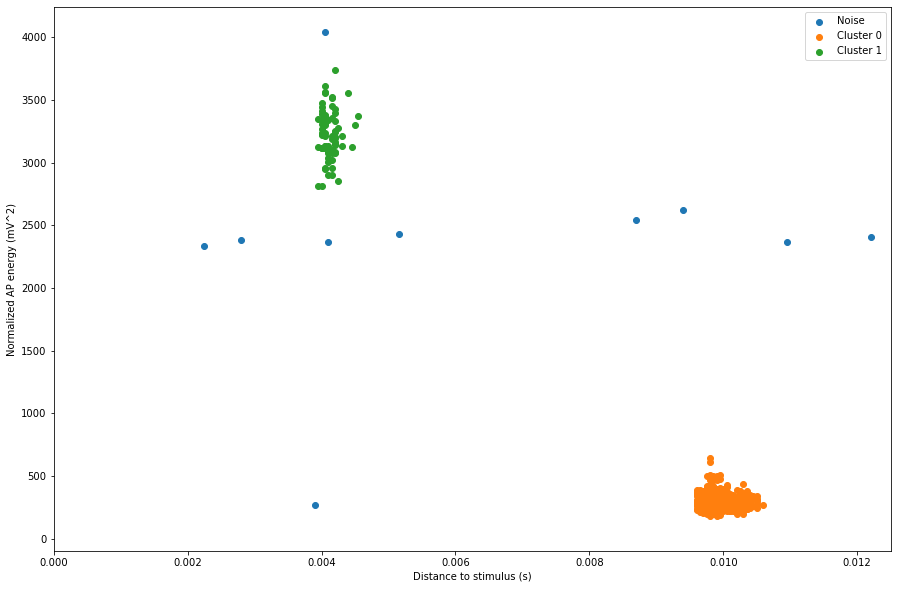

In [20]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
import clustering
# reload the clustering classes
# hacky workaround atm
import importlib
importlib.reload(clustering)

from sklearn.cluster import DBSCAN
import numpy as np

import matplotlib.pyplot as plt

# build feature vectors from the features provided by AP class
features = np.array([[ap.getDistanceToPreviousElectricalStimulus(), ap.getNormalizedEnergy()] for ap in actpots])
labels = DBSCAN(eps = 0.0025, min_samples = 10, metric = clustering.actionPotDistance_ElStim_Energy).fit_predict(features)
print("Clustering done.")

# initialize figure
plt.figure(figsize = (15, 10))

# where to save the results
results_folder = "../results/"
results_ending = ".png"

# iterate over all the clusters and plot them
cluster_index = -1
while cluster_index <= max(labels):
    # get a mask for all samples belonging to the cluster and retrieve those feature vectors
    indices = (labels == cluster_index)
    cluster_features = features[indices]
    # plot the cluster with the appropriate label
    # print("Plotting cluster: " + str(cluster_index))
    plt.scatter(x = cluster_features[: , 0], y = cluster_features[:, 1], label = "Cluster " + str(cluster_index) if cluster_index > -1 else "Noise")
    # go to the next cluster
    cluster_index = cluster_index + 1

plt.xlabel("Distance to stimulus (s)")
plt.xscale('linear')
plt.xlim(0, 0.0125)
plt.ylabel("Normalized AP energy (mV^2)")
plt.legend()
plt.savefig(results_folder + "dbscan_clustering_" + file_name + results_ending, dpi = 400)
plt.show()